In [1]:
from make_it_talk.models import *
from make_it_talk.scripts import *

/Users/antonbeletsky/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/antonbeletsky/opt/anaconda3/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
batch_size = 8
time = 32
h = 30
w = 40
audio_dim = 256

init_pictures = torch.rand((batch_size, h, w))
audios = torch.rand((batch_size, time, audio_dim))
true_videos = torch.rand((batch_size, time, h, w))

batch = (init_pictures, audios, true_videos)
loader = [batch]

In [5]:
pipeline = make_talking_head_pipeline(
    audio_to_embedding = AudioToEmbeddingPlug(audio_dim, 100, 101), # returns 100, 101
    lstm_speech_content = LSTMSpeechContentPlug(100, 102),
    lstm_speaker_aware = LSTMSpeakerAwarePlug(100, 103),
    mlp_speaker_embedding = MLPSpeakerEmbeddingPlug(101, 104),
    self_attention_encoder = SelfAttentionEncoderPlug(103 + 104, 105),
    facial_landmarks_extractor = FacialLandmarksExtractorPlug(h, w),
    mlp_speaker_aware = MLPSpeakerPlug(105 + 68*3, 68*3),
    mlp_speech_content = MLPContentPlug(102 + 68*3, 68*3),
    discriminator = DiscriminatorPlug(68*3, 103, 104)
)

In [7]:
#check that pipeline works

device='cpu'

pictures, audios, true_videos = batch

audios = audios.to(device)
pictures = pictures.to(device)
true_videos = true_videos.to(device)

predicted_landmarks, discriminator_input = pipeline(audios, pictures)

realism = pipeline.discriminator(*discriminator_input)

In [9]:
# check that train loop for content predictor works

optimizer = torch.optim.Adam(params=pipeline.parameters(), lr=1e-6)
loss_fn = (lambda x, y : (x + y).sum())
metric_fn = (lambda x, y : (x + y).sum() * 10)

log = train_content_landmarks_predictor(
        talking_head_pipeline=pipeline,
        optimizer=optimizer,
        dataloader=loader,
        n_epochs=30,
        device=device,
        loss_function=loss_fn,
        metrics_list=[metric_fn],
        training_log=None,
)

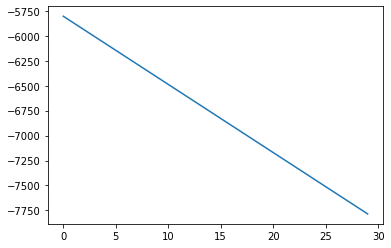

In [11]:
# check that loss drops with time
losses = [l['loss'] for l in log]
import matplotlib.pyplot as plt
plt.plot(losses)